In [188]:
import matplotlib.pyplot as plt
from numpy import linalg
import numpy as np

In [189]:
#%matplotlib notebook
%matplotlib inline

In [190]:
# delta robot param
# https://www.researchgate.net/publication/272747262_DEVELOPMENT_OF_A_PARALLEL_ROBOT_DELTA_KEOPS_WITH_MODIFIED_STRUCTURE

Rb = 1.0    # base radius
Rm = 0.2    # mobile platfrom radius

Lr = 1.2    # prismatic joint length
Le = 1.5    # link lengt

alpha = np.pi/4  # 45° = π/4

In [191]:
# rot matrix in z (120° = 2π/3)
rot_z_120 = np.array([
    [np.cos(2*np.pi/3),   -np.sin(2*np.pi/3), 0],
    [np.sin(2*np.pi/3),    np.cos(2*np.pi/3), 0],
    [0,                     0,                1]
])

In [192]:
def forward(joints):
    pass

inverse kinematic:\
$\vec{p} = [x\ y\ z]^T$\
\
$\alpha = 45° = \frac{pi}{4} rad$\
\
$R = \begin{bmatrix}1&0&0\\0&1&0\\0&0&1\end{bmatrix}$\
\
$R_{z120} = \begin{bmatrix}cos(\frac{2\pi}{3})& -sin(\frac{2\pi}{3})&0\\ sin(\frac{2\pi}{3})& cos(\frac{2\pi}{3})&0\\0&0&1\end{bmatrix}$\
\
$\vec{b_1} = [R_m\ 0\ 0]^T$\
$\vec{b_2} = R_{z120}*\vec{b_1}$\
$\vec{b_3} = R_{z120}^T*\vec{b_1}$\
\
$q_i = p + R * \vec{b_i}$\
\
$\vec{a_1} = [R_b\ 0\ 0]^T$\
$\vec{a_2} = R_{z120}*\vec{a_1}$\
$\vec{a_3} = R_{z120}^T*\vec{a_1}$\
\
$\vec{L_i} = \vec{q_i} - \vec{a_i}$\
\
$\vec{d0_1} = [-cos(\alpha)\ 0\ -sin(\alpha)]^T$\
$\vec{d0_2} = R_{z120}*\vec{d0_1}$\
$\vec{d0_3} = R_{z120}^T*\vec{d0_1}$\
\
$d_i = (\vec{L_i}*\vec{d0_i}) \pm \sqrt{(\vec{L_i}*\vec{d0_i})^2 -|L_i|^2 + L_e ^2}$
 


In [223]:
from matplotlib.patches import Circle, PathPatch

def draw_inverse(pos, draw_tcp_cart=False):
    
    plt.figure(figsize=(10,10))
    axlim = [-1.5, 1.5]
    ax = plt.axes(projection='3d')

    # ---- BASE ------
    # base corners top
    A1 = np.array([Rb, 0, 0])
    A2 = np.dot(rot_z_120, A1)
    A3 = np.dot(rot_z_120.T, A1)

    # draw base 
    ax.plot([A1[0], A2[0]], [A1[1], A2[1]], [A1[2], A2[2]], color="black", linewidth=2)
    ax.plot([A2[0], A3[0]], [A2[1], A3[1]], [A2[2], A3[2]], color="black", linewidth=2)
    ax.plot([A3[0], A1[0]], [A3[1], A1[1]], [A3[2], A1[2]], color="black", linewidth=2)

    # check axis length
    h = np.cos(alpha)*Lr 
    r = Rb - h

    # base corners bottom
    A1_d_max = np.array([r, 0, -h])
    A2_d_max = np.dot(rot_z_120, A1_d_max)
    A3_d_max = np.dot(rot_z_120.T, A1_d_max)
    
    # draw base circle
    t = np.linspace(0, 2*np.pi)
    ax.plot(np.sin(t)*r, np.cos(t)*r, -h, color="black", linewidth=2)
    
    # ---- ARMS ------
    # draw linear axis
    ax.plot([A1[0],A1_d_max[0]], [A1[1],A1_d_max[1]], [A1[2],A1_d_max[2]], color="black", linewidth=2)
    ax.plot([A2[0],A2_d_max[0]], [A2[1],A2_d_max[1]], [A2[2],A2_d_max[2]], color="black", linewidth=2)
    ax.plot([A3[0],A3_d_max[0]], [A3[1],A3_d_max[1]], [A3[2],A3_d_max[2]], color="black", linewidth=2)

    # inverse
    a = []
    a.append(np.array([Rb, 0, 0]))
    a.append(np.dot(rot_z_120, a[0]))
    a.append(np.dot(rot_z_120.T, a[0]))

    b = []
    b.append(np.array([Rm, 0, 0]))
    b.append(np.dot(rot_z_120, b[0]))
    b.append(np.dot(rot_z_120.T, b[0]))

    R = np.eye(3)
   
    q = []
    q.append(pos + np.matmul(R, b[0]))
    q.append(pos + np.matmul(R, b[1]))
    q.append(pos + np.matmul(R, b[2]))

    L = []
    L.append(q[0] - a[0])
    L.append(q[1] - a[1])
    L.append(q[2] - a[2])

    d0 = []
    d0.append(np.array([-np.cos(alpha), 0, -np.sin(alpha)]))
    d0.append(np.dot(rot_z_120, d0[0]))
    d0.append(np.dot(rot_z_120.T, d0[0]))

    d = np.zeros(3)
    h = np.zeros(3)
    
    for i in range(3):
        root = np.dot(L[i], d0[i])**2  - np.linalg.norm(L[i])**2 + Le**2
        if root < 0: raise Exception("Position not reachable!")
        d[i] = (np.dot(L[i], d0[i]) - np.sqrt(root))
        print(d[i])
        if not 0 <= d[i] <= Lr: raise Exception("Axis cannot move to this position!")
        h[i] = np.sin(alpha)*d[i]
        
    D1 = np.array([Rb-h[0], 0, -h[0]])
    D2 = np.array(np.dot(rot_z_120, [Rb-h[1], 0, -h[1]]))
    D3 = np.array(np.dot(rot_z_120.T, [Rb-h[2], 0, -h[2]]))

    # draw axis joints
    ax.scatter(D1[0], D1[1], D1[2], color="black")
    ax.scatter(D2[0], D2[1], D2[2], color="black")
    ax.scatter(D3[0], D3[1], D3[2], color="black")

    # draw arm
    ax.plot([D1[0], q[0][0]], [D1[1], q[0][1]], [D1[2], q[0][2]], color="black", linewidth=2)
    ax.plot([D2[0], q[1][0]], [D2[1], q[1][1]], [D2[2], q[1][2]], color="black", linewidth=2)
    ax.plot([D3[0], q[2][0]], [D3[1], q[2][1]], [D3[2], q[2][2]], color="black", linewidth=2)

    # ---- PLATFORM ------
    # draw platfrom center
    ax.scatter(q[0][0]-Rm, q[0][1], q[0][2], color="red")

    # draw platfrom
    ax.plot([q[0][0], q[1][0]], [q[0][1], q[1][1]], [q[0][2], q[1][2]], color="black", linewidth=2)
    ax.plot([q[1][0], q[2][0]], [q[1][1], q[2][1]], [q[1][2], q[2][2]], color="black", linewidth=2)
    ax.plot([q[2][0], q[0][0]], [q[2][1], q[0][1]], [q[2][2], q[0][2]], color="black", linewidth=2)

    # draw platfrom joints
    ax.scatter(q[0][0], q[0][1], q[0][2], color="black")
    ax.scatter(q[1][0], q[1][1], q[1][2], color="black")
    ax.scatter(q[2][0], q[2][1], q[2][2], color="black")

    # draw tcp cart
    if draw_tcp_cart:
        length = 0.4
        ax.plot([pos[0],pos[0]+length], [pos[1],pos[1]], [pos[2],pos[2]], color="red", linewidth=1)
        ax.plot([pos[0],pos[0]], [pos[1],pos[1]+length], [pos[2],pos[2]], color="green", linewidth=1)
        ax.plot([pos[0],pos[0]], [pos[1],pos[1]], [pos[2],pos[2]+length], color="blue", linewidth=1)

    """
    #--------------------------------
    # draw sphere test

    # draw sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x = Le*np.cos(u)*np.sin(v)
    y = Le*np.sin(u)*np.sin(v)
    z = Le*np.cos(v)
    

    #ax.plot_surface(x, y, z, color="red", alpha=0.2)
    #ax.plot_surface(x+D2[0], y+D2[1], z+D2[2], color="green", alpha=0.2)
    #ax.plot_surface(x+D3[0], y+D3[1], z+D3[2], color="blue", alpha=0.2)

    #--------------------------------
    """

    #di = (np.dot(L[0], d0[0]) - np.sqrt(np.dot(L[0], d0[0])**2  - np.linalg.norm(L[0])**2 - Le**2))
    #print(np.dot(L[0], d0[0]) - np.sqrt(np.dot(L[0], d0[0])**2  - np.linalg.norm(L[0])**2 + Le**2))

    ax.set_box_aspect(aspect=(1, 1, 1), zoom=0.90)
    ax.set_xlim(axlim)
    ax.set_xlabel('$X$', fontsize=14)
    ax.set_ylim(axlim)
    ax.set_ylabel('$Y$', fontsize=14)
    ax.set_zlim(axlim)
    ax.set_zlabel('$Z$', fontsize=14)
    
    #ax.invert_zaxis()
    ax.view_init(elev=0, azim=270, roll=0)

    return plt

Exception: Position not reachable!

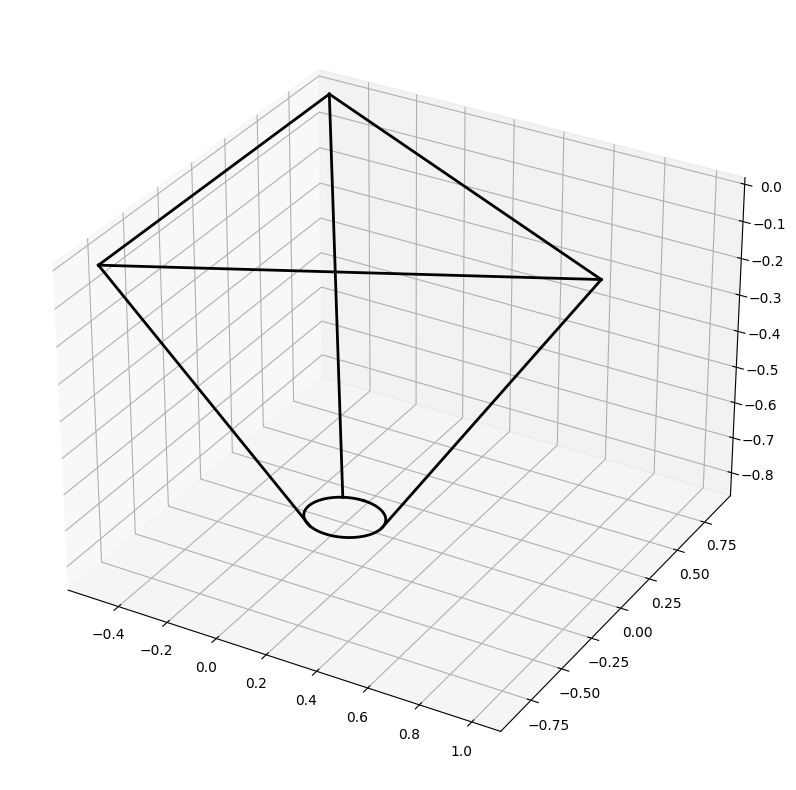

In [227]:
draw_inverse([0, 0, -3],draw_tcp_cart=False).show()

<img src="images/keops_x-axis.gif" alt="drawing" width="600"/>
<img src="images/keops_y-axis.gif" alt="drawing" width="600"/>
<br>
<img src="images/keops_z-axis.gif" alt="drawing" width="600"/>
<img src="images/keops_circle.gif" alt="drawing" width="600"/>